In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [2]:
df = pd.read_csv(r"C:\Users\rosem\Downloads\FINAL_PROJECT_WORKS\CSV_files\featue_engg_data1.csv")
#df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Hour,Demand,Net_Generation,Total_Interchange,Forecasted_Demand,Coal_Gen,Gas_Gen,Nuclear_Gen,Hydro_Gen,...,Season_Summer,Season_Winter,Demand_Prev_Hour,Demand_Yesterday_Same_Hour,Demand_Last_Week_Same_Hour,Rolling_Mean_3H,Rolling_Mean_24H,Total_Gen,Renewable_Pct,Fossil_Pct
0,2018-07-01 17:00:00,12.5,28976.042,21138.304,-6528.677,28386.220,8.764,7725.951,2261.073,3089.741,...,1,0,31560.368,97906.322,30623.583,52909.261,42604.509,17521.203,42.950,44.145
1,2018-07-01 18:00:00,12.5,29065.500,21217.885,-6554.521,28486.010,8.792,7761.917,2261.062,3110.594,...,1,0,19035.781,36973.722,30187.366,26585.677,41847.195,17577.073,42.927,44.209
2,2018-07-01 19:00:00,12.5,29154.958,21297.467,-6580.365,28585.800,8.819,7797.882,2261.052,3131.446,...,1,0,120405.354,28886.583,96196.009,60325.969,45629.697,17632.943,42.904,44.273
3,2018-07-01 20:00:00,12.5,29244.417,21377.049,-6606.208,28685.590,8.847,7833.847,2261.042,3152.299,...,1,0,8629.271,31655.750,35642.181,23684.576,48609.446,17688.812,42.881,44.337
4,2018-07-01 21:00:00,12.5,29333.875,21456.630,-6632.052,28785.380,8.875,7869.812,2261.031,3173.151,...,1,0,31562.326,29065.500,8211.854,30046.873,49142.567,17744.682,42.858,44.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525055,2023-06-29 20:00:00,12.5,64967.778,65025.979,58.042,65732.083,8989.486,27552.910,4647.181,32.896,...,1,0,40554.444,14324.708,37711.542,67747.671,49409.849,46077.069,10.607,79.307
525056,2023-06-29 21:00:00,12.5,64902.135,64963.474,61.177,65699.302,8993.729,27593.401,4647.292,33.224,...,1,0,31739.526,22046.601,65821.128,37511.137,46137.266,46106.208,10.566,79.354
525057,2023-06-29 22:00:00,12.5,64836.493,64900.969,64.312,65666.521,8997.972,27633.892,4647.403,33.552,...,1,0,15892.381,31801.521,21450.109,39168.139,45454.091,46135.347,10.526,79.401
525058,2023-06-29 23:00:00,12.5,64770.851,64838.464,67.448,65633.740,9002.215,27674.384,4647.514,33.880,...,1,0,22263.507,97828.229,41419.396,42477.179,39779.804,46164.486,10.485,79.448


In [3]:
df.dtypes

Date                           object
Hour                          float64
Demand                        float64
Net_Generation                float64
Total_Interchange             float64
Forecasted_Demand             float64
Coal_Gen                      float64
Gas_Gen                       float64
Nuclear_Gen                   float64
Hydro_Gen                     float64
Solar_Gen                     float64
CO2_Factor_Coal               float64
CO2_Factor_Gas                float64
CO2_Emissions_Coal            float64
CO2_Emissions_Gas             float64
CO2_Total_Emissions           float64
CO2_Intensity_Generated       float64
CO2_Intensity_Consumed        float64
Month                         float64
DayOfWeek                     float64
Is_Weekend                    float64
DayOfYear                     float64
WeekOfYear                    float64
Region                         object
Season_Autumn                   int64
Season_Spring                   int64
Season_Summe

In [4]:
# Load and prepare data
#df = pd.read_csv("featue_engg_data1.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Group by date for national data (summing values across regions per day)
national = df.groupby(df.index).agg({
    'Demand': 'sum',
    'CO2_Total_Emissions': 'sum',
    'Hour': 'mean',
    'Month': 'mean',
    'DayOfWeek': 'mean',
    'Is_Weekend': 'mean',
    'DayOfYear': 'mean',
    'WeekOfYear': 'mean',
    'Season_Autumn': 'mean',
    'Season_Spring': 'mean',
    'Season_Summer': 'mean',
    'Season_Winter': 'mean',
    'Renewable_Pct': 'mean',
    'Fossil_Pct': 'mean',
    'Demand_Prev_Hour': 'mean',
    'Demand_Yesterday_Same_Hour': 'mean',
    'Demand_Last_Week_Same_Hour': 'mean',
    'Rolling_Mean_3H': 'mean',
    'Rolling_Mean_24H': 'mean'
})

# Select features and targets
features = national[[
    'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'Renewable_Pct', 'Fossil_Pct',
    'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
    'Rolling_Mean_3H', 'Rolling_Mean_24H'
]]
targets = national[['Demand', 'CO2_Total_Emissions']]

# Scale both features and targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(targets)

# Convert to supervised sequences
def create_sequences(X, y, lookback=30, forecast_horizon=90):
    Xs, ys = [], []
    for i in range(len(X) - lookback - forecast_horizon):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback:i+lookback+forecast_horizon])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

# Define LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(y_seq.shape[1] * y_seq.shape[2])  # output shape: (forecast_horizon * num_targets)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_seq, y_seq.reshape(y_seq.shape[0], -1), epochs=2, batch_size=64)

# Forecast next 90 days
X_input = X_scaled[-30:]
forecast_scaled = model.predict(X_input.reshape(1, 30, X_seq.shape[2])).reshape(90, 2)
forecast = scaler_y.inverse_transform(forecast_scaled)


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
683/683 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.0431
Epoch 2/2
683/683 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
515/515 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0258
Epoch 2/2
515/515 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0021
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


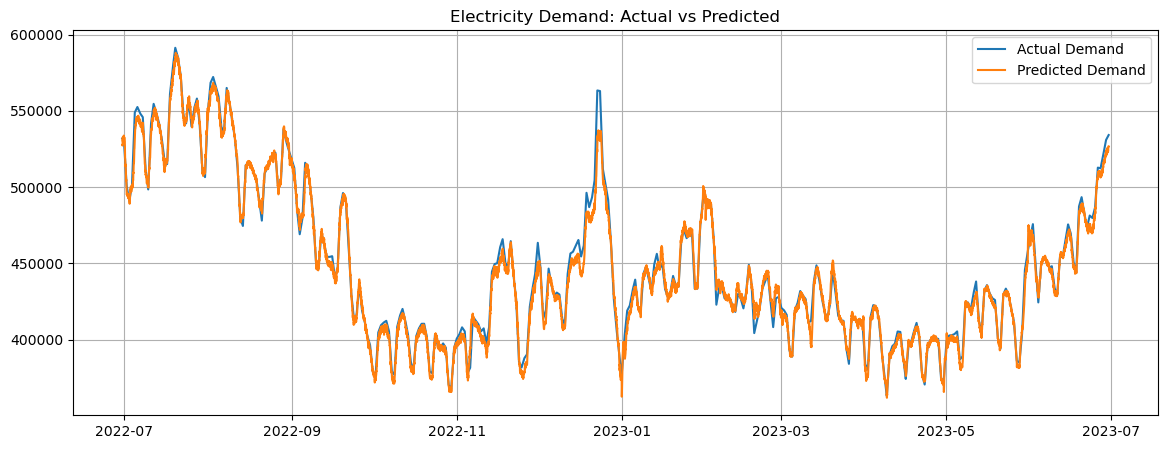

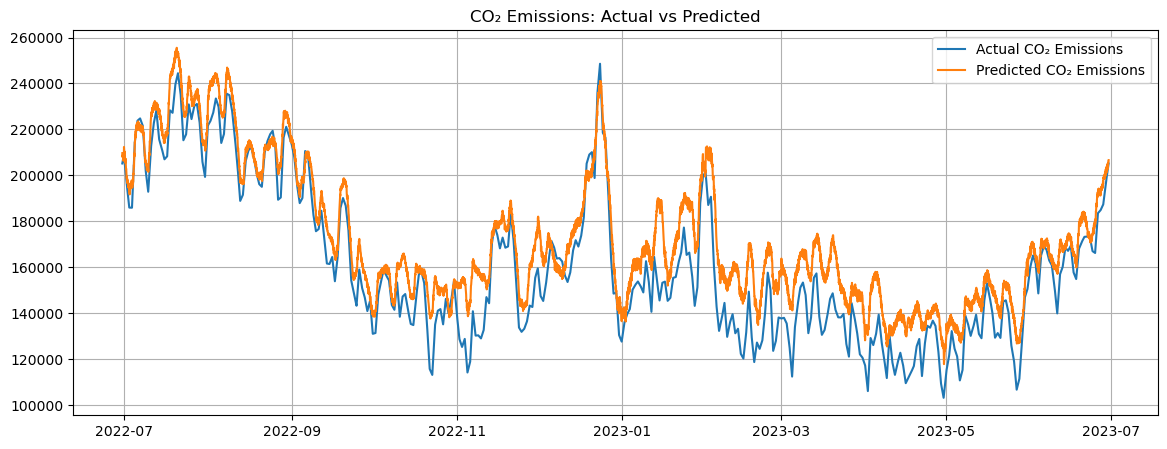

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


features = national[[
    'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'Renewable_Pct', 'Fossil_Pct',
    'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
    'Rolling_Mean_3H', 'Rolling_Mean_24H'
]]
targets = national[['Demand', 'CO2_Total_Emissions']]

# Scale
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(targets)

# Create sequences
def create_sequences(X, y, lookback=30):
    Xs, ys, y_actual = [], [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
        y_actual.append(i)  # save index for inverse mapping
    return np.array(Xs), np.array(ys), np.array(y_actual)

X_seq, y_seq, y_idx = create_sequences(X_scaled, y_scaled)

# -----------------------
# Step 2: Train/Test Split
# -----------------------
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
test_idx = y_idx[split:]

# -----------------------
# Step 3: Train LSTM
# -----------------------
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(2)  # single-step prediction (2 outputs)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=2, batch_size=68)

# -----------------------
# Step 4: Predict and Inverse Transform
# -----------------------
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# -----------------------
# Step 5: Plot Predictions vs Actuals
# -----------------------
dates = national.index[test_idx]

plt.figure(figsize=(14, 5))
plt.plot(dates, y_true[:, 0], label='Actual Demand')
plt.plot(dates, y_pred[:, 0], label='Predicted Demand')
plt.title('Electricity Demand: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(dates, y_true[:, 1], label='Actual CO₂ Emissions')
plt.plot(dates, y_pred[:, 1], label='Predicted CO₂ Emissions')
plt.title('CO₂ Emissions: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# -----------------------
# Step 6: Evaluation Metrics
# -----------------------

# Demand Metrics
rmse_demand = np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
mae_demand = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
mape_demand = mean_absolute_percentage_error(y_true[:, 0], y_pred[:, 0])

# CO₂ Metrics
rmse_co2 = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))
mae_co2 = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
mape_co2 = mean_absolute_percentage_error(y_true[:, 1], y_pred[:, 1])

# -----------------------
# Print Results
# -----------------------
print("✅ Electricity Demand Forecast Accuracy:")
print(f"RMSE: {rmse_demand:.2f}, MAE: {mae_demand:.2f}, MAPE: {mape_demand:.2f}%")

print("\n✅ CO₂ Emissions Forecast Accuracy:")
print(f"RMSE: {rmse_co2:.2f}, MAE: {mae_co2:.2f}, MAPE: {mape_co2:.2f}%")


✅ Electricity Demand Forecast Accuracy:
RMSE: 5178.65, MAE: 3645.52, MAPE: 0.81%

✅ CO₂ Emissions Forecast Accuracy:
RMSE: 14557.12, MAE: 12318.27, MAPE: 8.52%


# Cal and Tex

In [8]:
df = pd.read_csv(r"C:\Users\rosem\Downloads\FINAL_PROJECT_WORKS\CSV_files\featue_engg_data1.csv")
#df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Hour,Demand,Net_Generation,Total_Interchange,Forecasted_Demand,Coal_Gen,Gas_Gen,Nuclear_Gen,Hydro_Gen,...,Season_Summer,Season_Winter,Demand_Prev_Hour,Demand_Yesterday_Same_Hour,Demand_Last_Week_Same_Hour,Rolling_Mean_3H,Rolling_Mean_24H,Total_Gen,Renewable_Pct,Fossil_Pct
0,2018-07-01 17:00:00,12.5,28976.042,21138.304,-6528.677,28386.220,8.764,7725.951,2261.073,3089.741,...,1,0,31560.368,97906.322,30623.583,52909.261,42604.509,17521.203,42.950,44.145
1,2018-07-01 18:00:00,12.5,29065.500,21217.885,-6554.521,28486.010,8.792,7761.917,2261.062,3110.594,...,1,0,19035.781,36973.722,30187.366,26585.677,41847.195,17577.073,42.927,44.209
2,2018-07-01 19:00:00,12.5,29154.958,21297.467,-6580.365,28585.800,8.819,7797.882,2261.052,3131.446,...,1,0,120405.354,28886.583,96196.009,60325.969,45629.697,17632.943,42.904,44.273
3,2018-07-01 20:00:00,12.5,29244.417,21377.049,-6606.208,28685.590,8.847,7833.847,2261.042,3152.299,...,1,0,8629.271,31655.750,35642.181,23684.576,48609.446,17688.812,42.881,44.337
4,2018-07-01 21:00:00,12.5,29333.875,21456.630,-6632.052,28785.380,8.875,7869.812,2261.031,3173.151,...,1,0,31562.326,29065.500,8211.854,30046.873,49142.567,17744.682,42.858,44.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525055,2023-06-29 20:00:00,12.5,64967.778,65025.979,58.042,65732.083,8989.486,27552.910,4647.181,32.896,...,1,0,40554.444,14324.708,37711.542,67747.671,49409.849,46077.069,10.607,79.307
525056,2023-06-29 21:00:00,12.5,64902.135,64963.474,61.177,65699.302,8993.729,27593.401,4647.292,33.224,...,1,0,31739.526,22046.601,65821.128,37511.137,46137.266,46106.208,10.566,79.354
525057,2023-06-29 22:00:00,12.5,64836.493,64900.969,64.312,65666.521,8997.972,27633.892,4647.403,33.552,...,1,0,15892.381,31801.521,21450.109,39168.139,45454.091,46135.347,10.526,79.401
525058,2023-06-29 23:00:00,12.5,64770.851,64838.464,67.448,65633.740,9002.215,27674.384,4647.514,33.880,...,1,0,22263.507,97828.229,41419.396,42477.179,39779.804,46164.486,10.485,79.448


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred) 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def eval_region_prediction(region_code, display_name=None):
    print(f"\n📊 Evaluating prediction accuracy for {region_code}...")

    region_df = df[df['Region'] == region_code].copy()
    if region_df.empty:
        print(f"⚠️ No data found for region: {region_code}")
        return

    region_df['Date'] = pd.to_datetime(region_df['Date'])
    region_df.set_index('Date', inplace=True)

    daily_data = region_df.groupby(region_df.index).agg({
        'Demand': 'sum',
        'CO2_Total_Emissions': 'sum',
        'Hour': 'mean',
        'Month': 'mean',
        'DayOfWeek': 'mean',
        'Is_Weekend': 'mean',
        'DayOfYear': 'mean',
        'WeekOfYear': 'mean',
        'Season_Autumn': 'mean',
        'Season_Spring': 'mean',
        'Season_Summer': 'mean',
        'Season_Winter': 'mean',
        'Renewable_Pct': 'mean',
        'Fossil_Pct': 'mean',
        'Demand_Prev_Hour': 'mean',
        'Demand_Yesterday_Same_Hour': 'mean',
        'Demand_Last_Week_Same_Hour': 'mean',
        'Rolling_Mean_3H': 'mean',
        'Rolling_Mean_24H': 'mean'
    })

    features = daily_data[[
        'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
        'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
        'Renewable_Pct', 'Fossil_Pct',
        'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
        'Rolling_Mean_3H', 'Rolling_Mean_24H'
    ]]
    targets = daily_data[['Demand', 'CO2_Total_Emissions']]

    # Scale
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(targets)

    def create_sequences(X, y, lookback=30):
        Xs, ys, idxs = [], [], []
        for i in range(lookback, len(X)):
            Xs.append(X[i-lookback:i])
            ys.append(y[i])
            idxs.append(i)
        return np.array(Xs), np.array(ys), np.array(idxs)

    X_seq, y_seq, idx_seq = create_sequences(X_scaled, y_scaled)

    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    test_idx = idx_seq[split:]

    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=2, batch_size=64, verbose=0)

    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)
    test_dates = daily_data.index[test_idx]
    title_name = display_name if display_name else region_code

    # 📏 Accuracy metrics
    mae_demand = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_demand = np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mape_demand = mean_absolute_percentage_error(y_true[:, 0], y_pred[:, 0])

    mae_co2 = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_co2 = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))
    mape_co2 = mean_absolute_percentage_error(y_true[:, 1], y_pred[:, 1])

    print(f"--- {title_name} ---")
    print(f"Electricity Demand → MAE: {mae_demand:.2f}, RMSE: {rmse_demand:.2f}, MAPE: {mape_demand:.2f}%")
    print(f"CO₂ Emissions      → MAE: {mae_co2:.2f}, RMSE: {rmse_co2:.2f}, MAPE: {mape_co2:.2f}%\n")

    # Plot Demand
    plt.figure(figsize=(14, 5))
    plt.plot(test_dates, y_true[:, 0], label='Actual Demand')
    plt.plot(test_dates, y_pred[:, 0], label='Predicted Demand')
    plt.title(f"{title_name} – Electricity Demand\nMAE: {mae_demand:.2f}, RMSE: {rmse_demand:.2f}, MAPE: {mape_demand:.2f}%")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot CO₂
    plt.figure(figsize=(14, 5))
    plt.plot(test_dates, y_true[:, 1], label='Actual CO₂ Emissions')
    plt.plot(test_dates, y_pred[:, 1], label='Predicted CO₂ Emissions')
    plt.title(f"{title_name} – CO₂ Emissions\nMAE: {mae_co2:.2f}, RMSE: {rmse_co2:.2f}, MAPE: {mape_co2:.2f}%")
    plt.legend()
    plt.grid(True)
    plt.show()

    return y_true, y_pred, y_test, test_idx, daily_data, {
    'Region': display_name or region_code,
    'Demand': {
        'MAE': mae_demand,
        'RMSE': rmse_demand,
        'MAPE': mape_demand
    },
    'CO2': {
        'MAE': mae_co2,
        'RMSE': rmse_co2,
        'MAPE': mape_co2
        }
    }



📊 Evaluating prediction accuracy for CAL...


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
--- California ---
Electricity Demand → MAE: 1296.80, RMSE: 1671.74, MAPE: 4.16%
CO₂ Emissions      → MAE: 500.39, RMSE: 637.39, MAPE: 9.06%



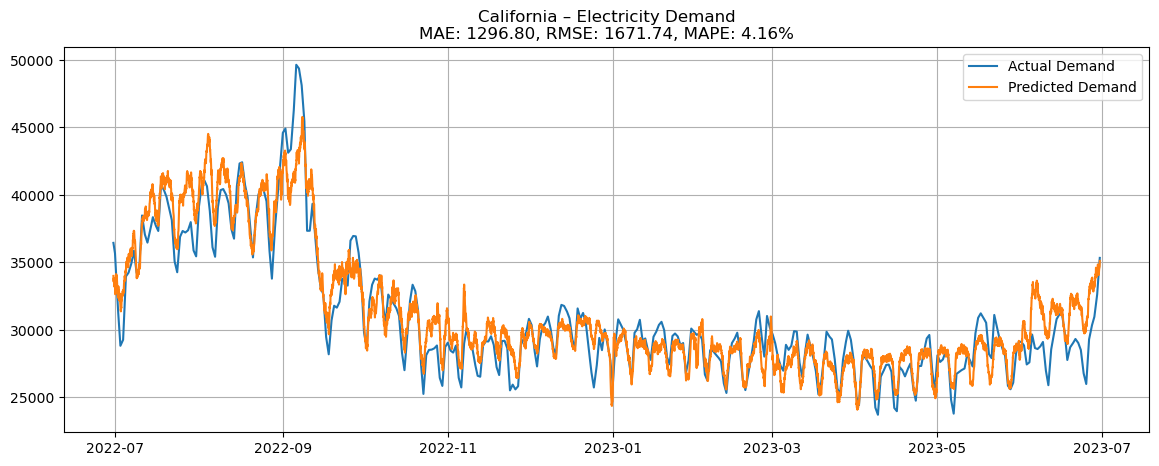

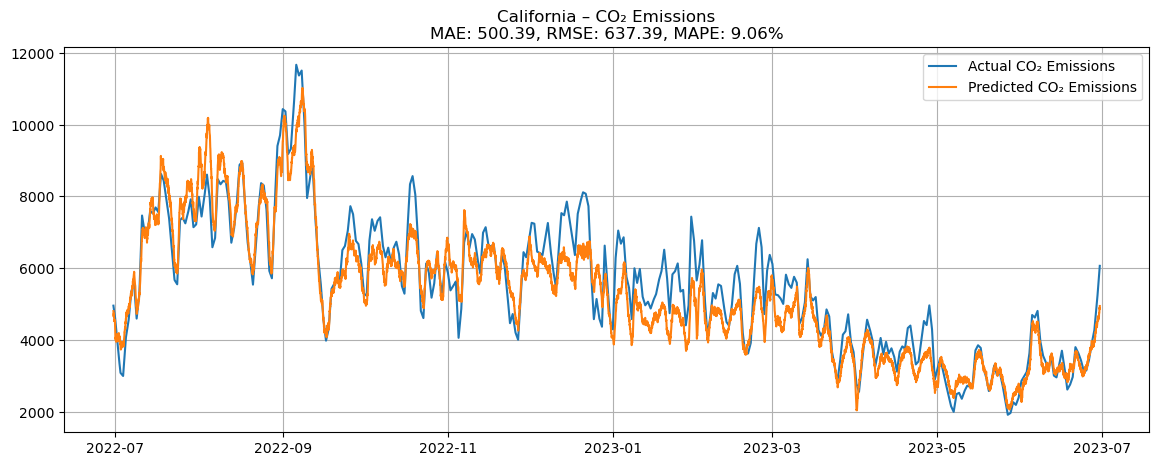


📊 Evaluating prediction accuracy for TEX...


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
--- Texas ---
Electricity Demand → MAE: 2571.40, RMSE: 3257.51, MAPE: 5.15%
CO₂ Emissions      → MAE: 1345.75, RMSE: 1663.36, MAPE: 9.35%



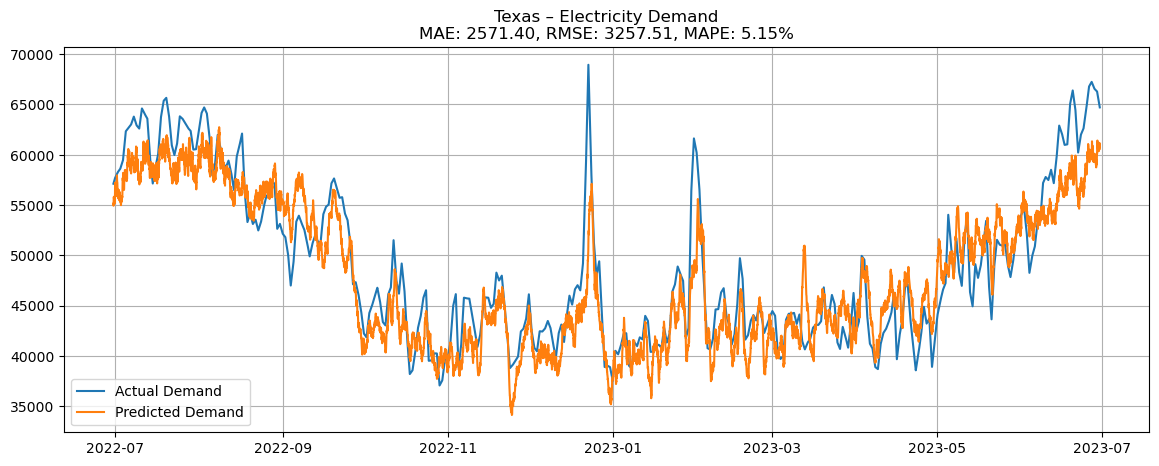

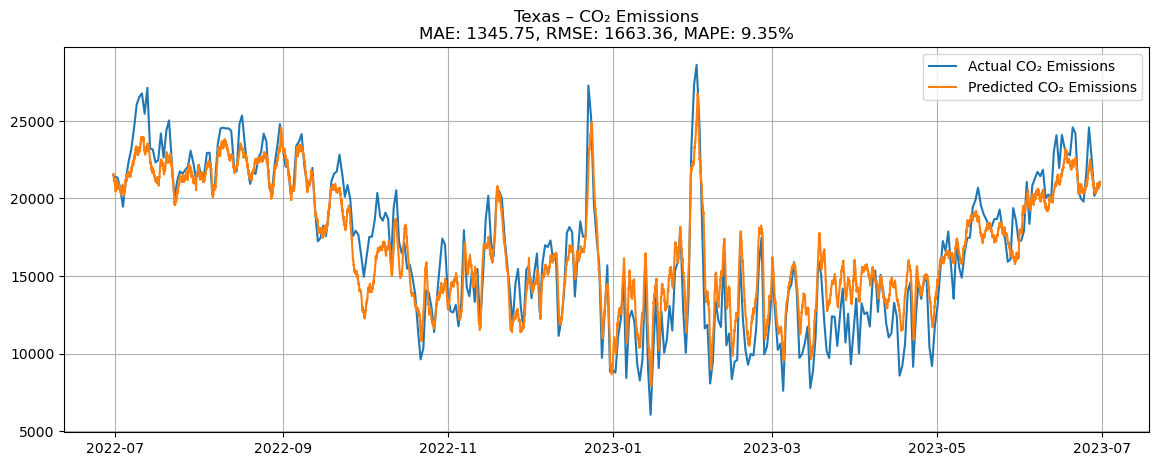

In [10]:
y_true, y_pred, y_test, test_idx, daily_data, cal_metrics = eval_region_prediction("CAL", "California")
y_true, y_pred, y_test, test_idx, daily_data, tex_metrics = eval_region_prediction("TEX", "Texas")

In [11]:
def simulate_renewable_scenarios(region_code, display_name=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import MinMaxScaler
    import numpy as np
    import pandas as pd
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    import tensorflow as tf

    print(f"\n🌱 Simulating renewable energy scenarios for {region_code}...")
    # Set seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    lookback = 15  # LSTM rolling window

    # 1️⃣ Data Preparation
    region_df = df[df['Region'] == region_code].copy()
    region_df['Date'] = pd.to_datetime(region_df['Date'])
    region_df.set_index('Date', inplace=True)

    # Aggregate daily
    daily_data = region_df.groupby(region_df.index).agg({
        'Demand': 'sum',
        'CO2_Total_Emissions': 'sum',
        'Hour': 'mean',
        'Month': 'mean',
        'DayOfWeek': 'mean',
        'Is_Weekend': 'mean',
        'DayOfYear': 'mean',
        'WeekOfYear': 'mean',
        'Season_Autumn': 'mean',
        'Season_Spring': 'mean',
        'Season_Summer': 'mean',
        'Season_Winter': 'mean',
        'Renewable_Pct': 'mean',
        'Fossil_Pct': 'mean',
        'Demand_Prev_Hour': 'mean',
        'Demand_Yesterday_Same_Hour': 'mean',
        'Demand_Last_Week_Same_Hour': 'mean',
        'Rolling_Mean_3H': 'mean',
        'Rolling_Mean_24H': 'mean'
    })

    features = daily_data[[
        'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
        'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
        'Renewable_Pct', 'Fossil_Pct',
        'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
        'Rolling_Mean_3H', 'Rolling_Mean_24H'
    ]]
    targets = daily_data[['Demand', 'CO2_Total_Emissions']]

    # Scale
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(targets)

    max_rows = 20000
    X_scaled = X_scaled[-max_rows:]
    y_scaled = y_scaled[-max_rows:]
    dates_all = daily_data.index[-max_rows:]

    # Sequences
    def create_sequences(X, y, dates, lookback):
        Xs, ys, idxs = [], [], []
        for i in range(lookback, len(X)):
            Xs.append(X[i - lookback:i])
            ys.append(y[i])
            idxs.append(dates[i])
        return np.array(Xs), np.array(ys), idxs

    X_seq, y_seq, idx_seq = create_sequences(X_scaled, y_scaled, dates_all, lookback)

    # 2️⃣ Train LSTM
    model = Sequential([
        LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])),
        Dense(2)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_seq, y_seq, epochs=2, batch_size=64, verbose=0)

    # 3️⃣ Simulate FUTURE (2023–2024)
    future_dates = pd.date_range(start=daily_data.index[-1] + pd.Timedelta(days=1), periods=365, freq='D')

    base_df = pd.DataFrame({
        'Date': future_dates,
        'Hour': 12,
        'Month': future_dates.month,
        'DayOfWeek': future_dates.dayofweek,
        'Is_Weekend': future_dates.dayofweek.isin([5, 6]).astype(int),
        'DayOfYear': future_dates.dayofyear,
        'WeekOfYear': future_dates.isocalendar().week,
        'Season_Winter': ((future_dates.month <= 2) | (future_dates.month == 12)).astype(int),
        'Season_Spring': future_dates.month.isin([3, 4, 5]).astype(int),
        'Season_Summer': future_dates.month.isin([6, 7, 8]).astype(int),
        'Season_Autumn': future_dates.month.isin([9, 10, 11]).astype(int),
    })

    for col in ['Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
                'Rolling_Mean_3H', 'Rolling_Mean_24H']:
        base_df[col] = region_df[col].mean()

    renew_base = region_df['Renewable_Pct'].mean()
    fossil_base = region_df['Fossil_Pct'].mean()

    scenarios = {
        "Base": (renew_base, fossil_base),
        "+10% Renewables": (min(renew_base + 10, 100), max(fossil_base - 10, 0)),
        "+20% Renewables": (min(renew_base + 20, 100), max(fossil_base - 20, 0)),
        "+30% Renewables": (min(renew_base + 30, 100), max(fossil_base - 30, 0)),
    }

    predictions_future = {}
    for name, (renew, fossil) in scenarios.items():
        df_copy = base_df.copy()
        df_copy['Renewable_Pct'] = renew
        df_copy['Fossil_Pct'] = fossil
        df_copy = df_copy[features.columns]
        scaled = scaler_X.transform(df_copy)

        input_seq = X_scaled[-lookback:].copy()
        forecast_scaled = []
        for i in range(365):
            input_seq = np.vstack([input_seq[1:], scaled[i]])
            pred = model.predict(input_seq.reshape(1, lookback, X_scaled.shape[1]), verbose=0)[0]
            forecast_scaled.append(pred)
        forecast = scaler_y.inverse_transform(forecast_scaled)
        predictions_future[name] = forecast[:, 1]

    # 4️⃣ Historical simulation with changed renewables
    recent_df = features.tail(365).copy()
    base_emissions_hist = scaler_y.inverse_transform(y_scaled[-365:])[:, 1]
    predictions_hist = {}

    for name, (renew, fossil) in scenarios.items():
        mod_df = recent_df.copy()
        mod_df['Renewable_Pct'] = renew
        mod_df['Fossil_Pct'] = fossil
        scaled_mod = scaler_X.transform(mod_df)
        input_seq = X_scaled[-(365 + lookback):-365]  # use prior window

        forecast_scaled = []
        for i in range(365):
            input_seq = np.vstack([input_seq[1:], scaled_mod[i]])
            pred = model.predict(input_seq.reshape(1, lookback, X_scaled.shape[1]), verbose=0)[0]
            forecast_scaled.append(pred)
        forecast = scaler_y.inverse_transform(forecast_scaled)
        predictions_hist[name] = forecast[:, 1]

    # 5️⃣ Plot Historical Impact
    plt.figure(figsize=(14, 5))
    plt.plot(dates_all[-365:], base_emissions_hist, label='Actual CO2 Emissions', color='black')
    plt.plot(dates_all[-365:], predictions_hist["+30% Renewables"], label='Simulated CO2 (+30% Renewables)', color='green')
    plt.title(f"{display_name or region_code}: Historical Simulation of CO2 Emissions with Renewables")
    plt.xlabel("Date")
    plt.ylabel("CO2 Emissions (tons)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 6️⃣ Plot Future Scenario
    base_scaled = MinMaxScaler().fit_transform(predictions_future["Base"].reshape(-1, 1)).flatten()
    sim_scaled = MinMaxScaler().fit_transform(predictions_future["+30% Renewables"].reshape(-1, 1)).flatten()

    plt.figure(figsize=(14, 5))
    plt.plot(future_dates, base_scaled, label="Original CO2 Emissions", color='orange')
    plt.plot(future_dates, sim_scaled, label="Simulated CO2 (30% more renewables)", color='green')
    plt.title(f"{display_name or region_code}: Future CO2 Emissions Forecast with 30% Renewables")
    plt.xlabel("Date")
    plt.ylabel("CO2 Emissions (Scaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'Region': display_name or region_code,
        'Historical_Base_CO2': np.sum(base_emissions_hist),
        'Historical_30%Renew_CO2': np.sum(predictions_hist["+30% Renewables"]),
        'Future_Base_CO2': np.sum(predictions_future["Base"]),
        'Future_30%Renew_CO2': np.sum(predictions_future["+30% Renewables"])
    }



🌱 Simulating renewable energy scenarios for CAL...


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


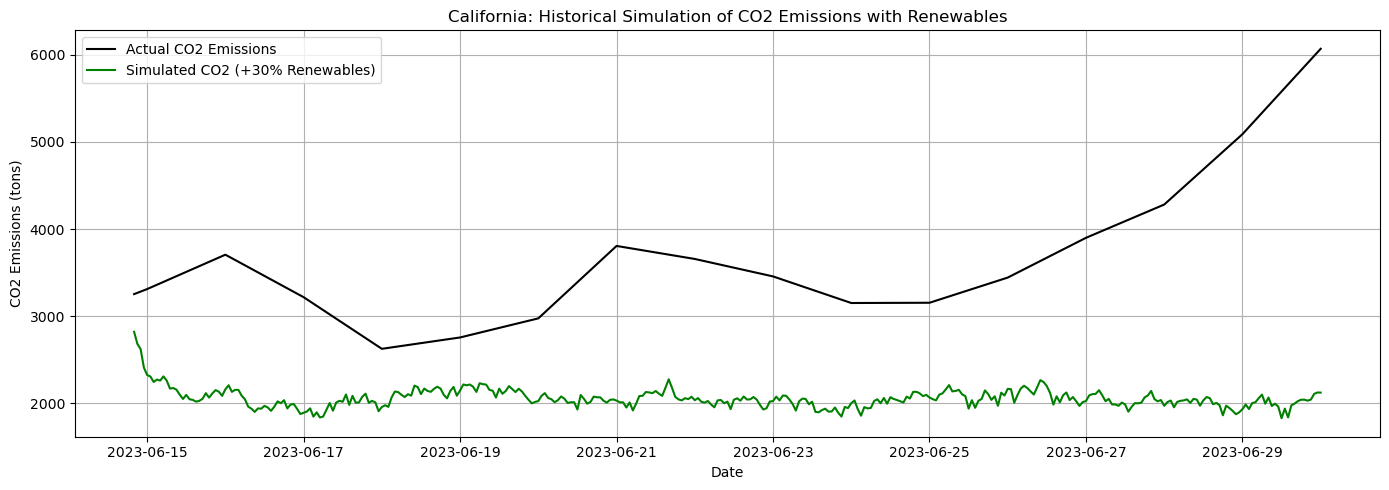

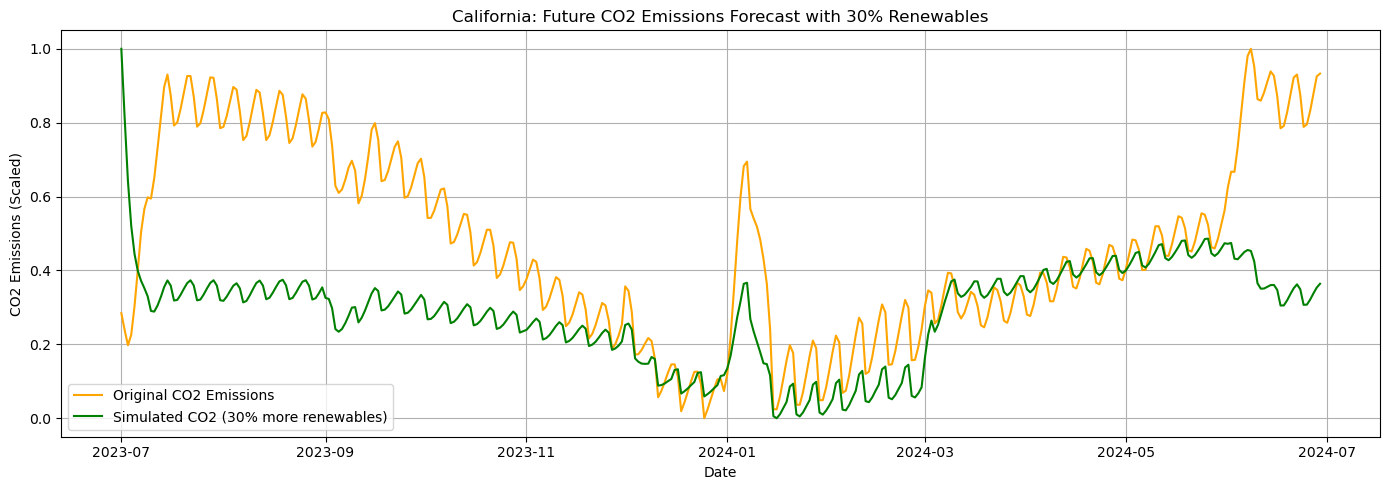


🌱 Simulating renewable energy scenarios for TEX...


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


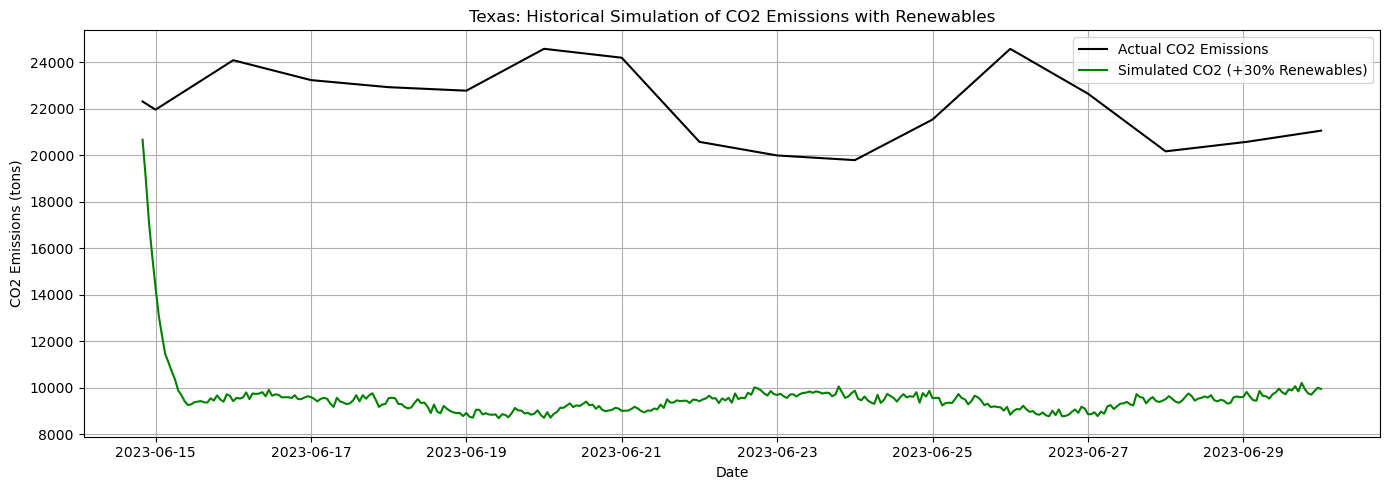

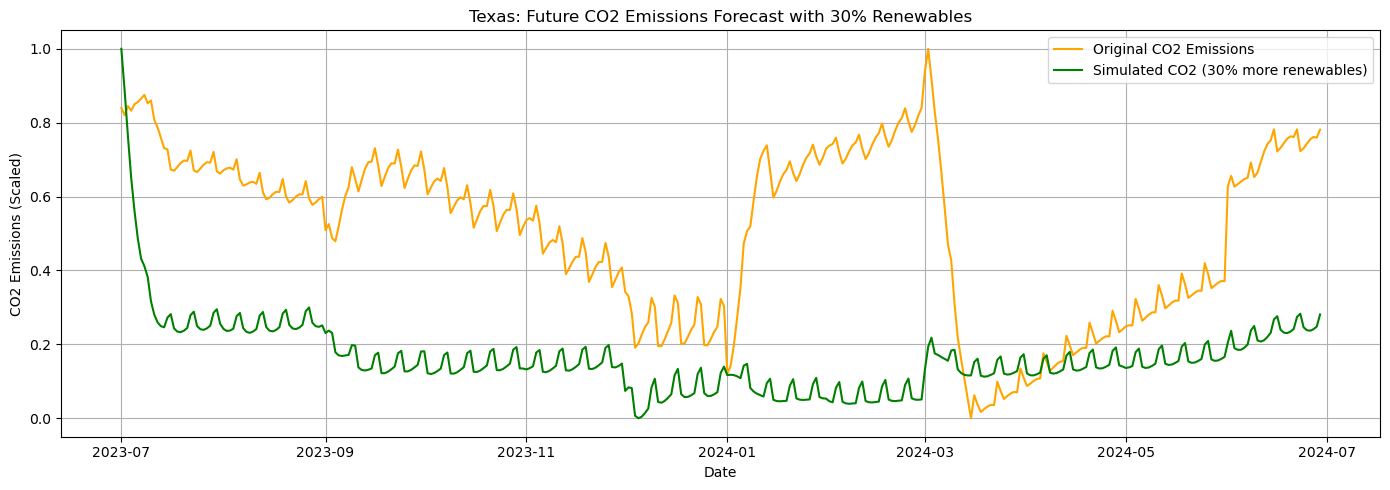

In [12]:
cal_results = simulate_renewable_scenarios("CAL", "California")
tex_results = simulate_renewable_scenarios("TEX", "Texas")

In [13]:
if isinstance(cal_results, dict):
    cal_results = [cal_results]
if isinstance(tex_results, dict):
    tex_results = [tex_results]

results_df = pd.DataFrame(cal_results + tex_results)

In [14]:
# Calculate CO₂ reduction percent for historical and future
results_df['Historical_CO2_Reduction_Percent'] = (
    (results_df['Historical_Base_CO2'] - results_df['Historical_30%Renew_CO2']) / results_df['Historical_Base_CO2']
) * 100

results_df['Future_CO2_Reduction_Percent'] = (
    (results_df['Future_Base_CO2'] - results_df['Future_30%Renew_CO2']) / results_df['Future_Base_CO2']
) * 100


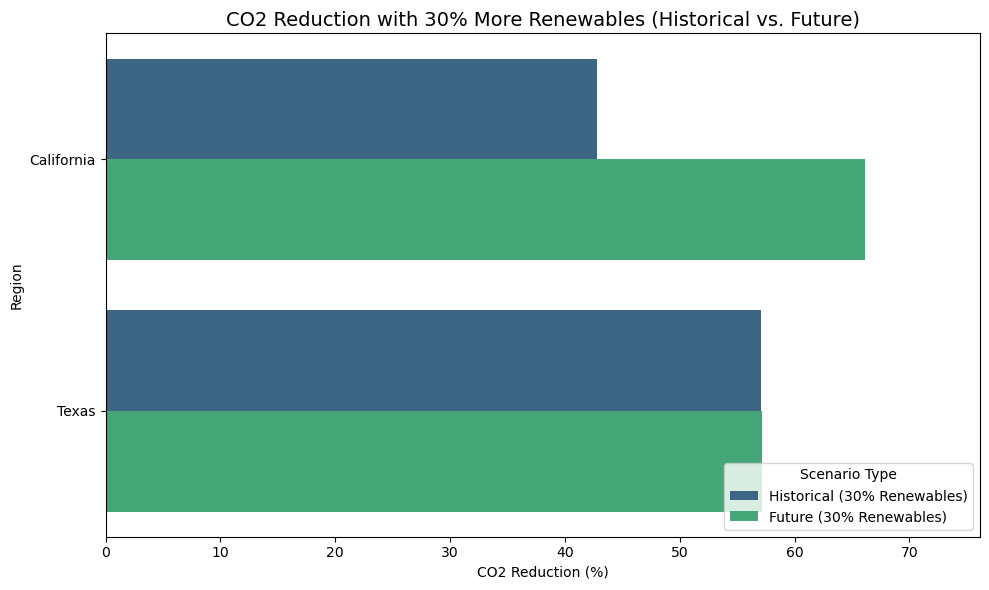

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt for easier plotting
melted_df = results_df.melt(
    id_vars='Region',
    value_vars=['Historical_CO2_Reduction_Percent', 'Future_CO2_Reduction_Percent'],
    var_name='Scenario_Type',
    value_name='Reduction_Percent'
)

# Rename for clarity
melted_df['Scenario_Type'] = melted_df['Scenario_Type'].replace({
    'Historical_CO2_Reduction_Percent': 'Historical (30% Renewables)',
    'Future_CO2_Reduction_Percent': 'Future (30% Renewables)'
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=melted_df,
    x='Reduction_Percent',
    y='Region',
    hue='Scenario_Type',
    palette='viridis'
)
    
plt.title("CO2 Reduction with 30% More Renewables (Historical vs. Future)", fontsize=14)
plt.xlabel("CO2 Reduction (%)")
plt.ylabel("Region")
plt.legend(title="Scenario Type", loc='lower right')
plt.xlim(0, melted_df['Reduction_Percent'].max() + 10)
plt.tight_layout()
plt.show()


In [16]:
summary = results_df[['Region', 'Historical_CO2_Reduction_Percent', 'Future_CO2_Reduction_Percent']].copy()
summary['Historical_CO2_Reduction_Percent'] = summary['Historical_CO2_Reduction_Percent'].map('{:.2f}%'.format)
summary['Future_CO2_Reduction_Percent'] = summary['Future_CO2_Reduction_Percent'].map('{:.2f}%'.format)

print(summary.to_string(index=False))

    Region Historical_CO2_Reduction_Percent Future_CO2_Reduction_Percent
California                           42.79%                       66.15%
     Texas                           57.04%                       57.18%


# RNN

In [18]:
df = pd.read_csv(r"C:\Users\rosem\Downloads\FINAL_PROJECT_WORKS\CSV_files\featue_engg_data1.csv")
#df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Hour,Demand,Net_Generation,Total_Interchange,Forecasted_Demand,Coal_Gen,Gas_Gen,Nuclear_Gen,Hydro_Gen,...,Season_Summer,Season_Winter,Demand_Prev_Hour,Demand_Yesterday_Same_Hour,Demand_Last_Week_Same_Hour,Rolling_Mean_3H,Rolling_Mean_24H,Total_Gen,Renewable_Pct,Fossil_Pct
0,2018-07-01 17:00:00,12.5,28976.042,21138.304,-6528.677,28386.220,8.764,7725.951,2261.073,3089.741,...,1,0,31560.368,97906.322,30623.583,52909.261,42604.509,17521.203,42.950,44.145
1,2018-07-01 18:00:00,12.5,29065.500,21217.885,-6554.521,28486.010,8.792,7761.917,2261.062,3110.594,...,1,0,19035.781,36973.722,30187.366,26585.677,41847.195,17577.073,42.927,44.209
2,2018-07-01 19:00:00,12.5,29154.958,21297.467,-6580.365,28585.800,8.819,7797.882,2261.052,3131.446,...,1,0,120405.354,28886.583,96196.009,60325.969,45629.697,17632.943,42.904,44.273
3,2018-07-01 20:00:00,12.5,29244.417,21377.049,-6606.208,28685.590,8.847,7833.847,2261.042,3152.299,...,1,0,8629.271,31655.750,35642.181,23684.576,48609.446,17688.812,42.881,44.337
4,2018-07-01 21:00:00,12.5,29333.875,21456.630,-6632.052,28785.380,8.875,7869.812,2261.031,3173.151,...,1,0,31562.326,29065.500,8211.854,30046.873,49142.567,17744.682,42.858,44.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525055,2023-06-29 20:00:00,12.5,64967.778,65025.979,58.042,65732.083,8989.486,27552.910,4647.181,32.896,...,1,0,40554.444,14324.708,37711.542,67747.671,49409.849,46077.069,10.607,79.307
525056,2023-06-29 21:00:00,12.5,64902.135,64963.474,61.177,65699.302,8993.729,27593.401,4647.292,33.224,...,1,0,31739.526,22046.601,65821.128,37511.137,46137.266,46106.208,10.566,79.354
525057,2023-06-29 22:00:00,12.5,64836.493,64900.969,64.312,65666.521,8997.972,27633.892,4647.403,33.552,...,1,0,15892.381,31801.521,21450.109,39168.139,45454.091,46135.347,10.526,79.401
525058,2023-06-29 23:00:00,12.5,64770.851,64838.464,67.448,65633.740,9002.215,27674.384,4647.514,33.880,...,1,0,22263.507,97828.229,41419.396,42477.179,39779.804,46164.486,10.485,79.448


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [20]:
region_df = df[df['Region'] == 'CAL'].copy()  # Example for California
region_df['Date'] = pd.to_datetime(region_df['Date'])
region_df.set_index('Date', inplace=True)

# Daily aggregation
daily_data = region_df.groupby(region_df.index).agg({
    'Demand': 'sum',
    'CO2_Total_Emissions': 'sum',
    'Hour': 'mean',
    'Month': 'mean',
    'DayOfWeek': 'mean',
    'Is_Weekend': 'mean',
    'DayOfYear': 'mean',
    'WeekOfYear': 'mean',
    'Season_Autumn': 'mean',
    'Season_Spring': 'mean',
    'Season_Summer': 'mean',
    'Season_Winter': 'mean',
    'Renewable_Pct': 'mean',
    'Fossil_Pct': 'mean',
    'Demand_Prev_Hour': 'mean',
    'Demand_Yesterday_Same_Hour': 'mean',
    'Demand_Last_Week_Same_Hour': 'mean',
    'Rolling_Mean_3H': 'mean',
    'Rolling_Mean_24H': 'mean'
})


In [21]:
features = daily_data[[  # Same features
    'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'Renewable_Pct', 'Fossil_Pct',
    'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
    'Rolling_Mean_3H', 'Rolling_Mean_24H'
]]
targets = daily_data[['Demand', 'CO2_Total_Emissions']]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(targets)

In [22]:
def create_sequences(X, y, lookback=30):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

In [23]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


In [24]:
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),  # RNN Layer
    Dense(2)  # 2 outputs: Demand, CO2
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=2, batch_size=64, verbose=1)

Epoch 1/2


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0305
Epoch 2/2
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0054


In [25]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [26]:
test_dates = daily_data.index[30 + split:]  # Adjusted for lookback offset

rnn_results_df = pd.DataFrame({
    'Date': test_dates,
    'Region': 'California',
    'Model': 'RNN',
    'Actual_Demand': y_true[:, 0],
    'Predicted_Demand': y_pred[:, 0],
    'Actual_CO2': y_true[:, 1],
    'Predicted_CO2': y_pred[:, 1]
})

rnn_results_df.to_csv('rnn_california_forecast.csv', index=False)

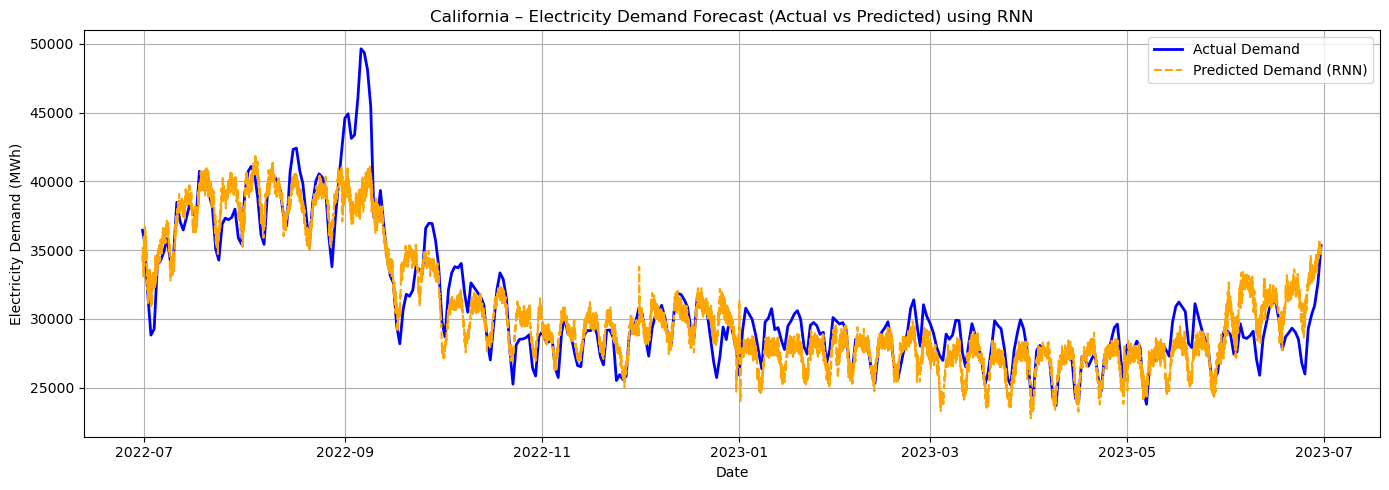

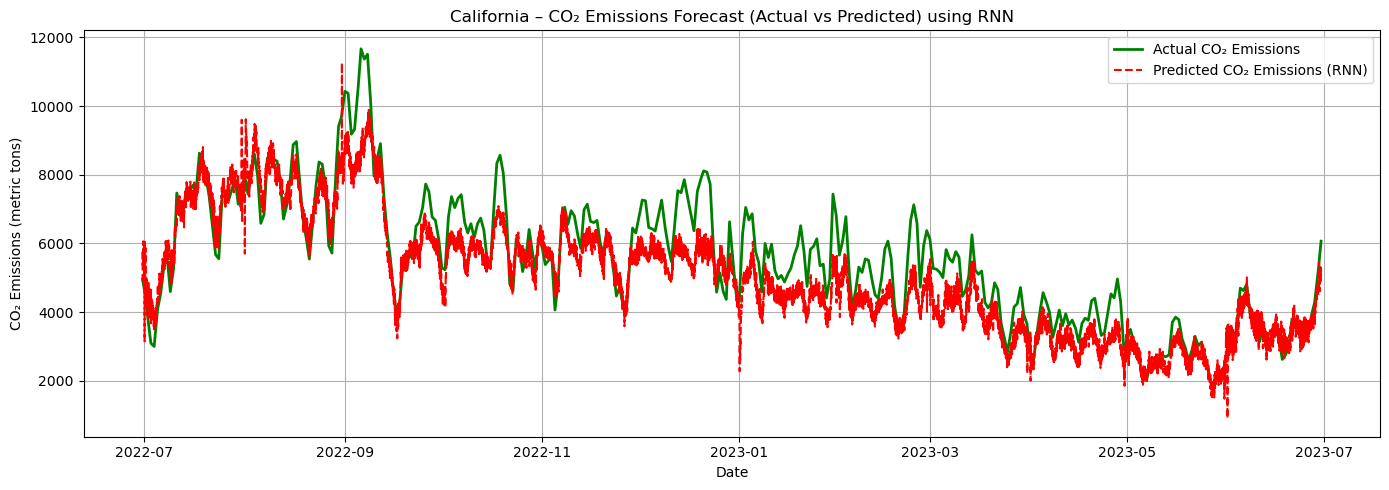

In [27]:
import matplotlib.pyplot as plt

# ----------------------
# Plot: Electricity Demand
# ----------------------
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true[:, 0], label='Actual Demand', color='blue', linewidth=2)
plt.plot(test_dates, y_pred[:, 0], label='Predicted Demand (RNN)', color='orange', linestyle='--')
plt.title('California – Electricity Demand Forecast (Actual vs Predicted) using RNN')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------
# Plot: CO₂ Emissions
# ----------------------
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true[:, 1], label='Actual CO₂ Emissions', color='green', linewidth=2)
plt.plot(test_dates, y_pred[:, 1], label='Predicted CO₂ Emissions (RNN)', color='red', linestyle='--')
plt.title('California – CO₂ Emissions Forecast (Actual vs Predicted) using RNN')
plt.xlabel('Date')
plt.ylabel('CO₂ Emissions (metric tons)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
region_df_tex = df[df['Region'] == 'TEX'].copy()  # Example for California
region_df_tex['Date'] = pd.to_datetime(region_df_tex['Date'])
region_df_tex.set_index('Date', inplace=True)

# Daily aggregation
daily_data = region_df_tex.groupby(region_df_tex.index).agg({
    'Demand': 'sum',
    'CO2_Total_Emissions': 'sum',
    'Hour': 'mean',
    'Month': 'mean',
    'DayOfWeek': 'mean',
    'Is_Weekend': 'mean',
    'DayOfYear': 'mean',
    'WeekOfYear': 'mean',
    'Season_Autumn': 'mean',
    'Season_Spring': 'mean',
    'Season_Summer': 'mean',
    'Season_Winter': 'mean',
    'Renewable_Pct': 'mean',
    'Fossil_Pct': 'mean',
    'Demand_Prev_Hour': 'mean',
    'Demand_Yesterday_Same_Hour': 'mean',
    'Demand_Last_Week_Same_Hour': 'mean',
    'Rolling_Mean_3H': 'mean',
    'Rolling_Mean_24H': 'mean'
})


In [29]:
features = daily_data[[  # Same features
    'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
    'Renewable_Pct', 'Fossil_Pct',
    'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
    'Rolling_Mean_3H', 'Rolling_Mean_24H'
]]
targets = daily_data[['Demand', 'CO2_Total_Emissions']]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(targets)

In [30]:
def create_sequences(X, y, lookback=30):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)

In [31]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [32]:
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),  # RNN Layer
    Dense(2)  # 2 outputs: Demand, CO2
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=2, batch_size=64, verbose=1)

Epoch 1/2


C:\Users\rosem\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0440
Epoch 2/2
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0059


In [33]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [34]:
test_dates = daily_data.index[30 + split:]  # Adjusted for lookback offset

rnn_results_df = pd.DataFrame({
    'Date': test_dates,
    'Region': 'Texas',
    'Model': 'RNN',
    'Actual_Demand': y_true[:, 0],
    'Predicted_Demand': y_pred[:, 0],
    'Actual_CO2': y_true[:, 1],
    'Predicted_CO2': y_pred[:, 1]
})

rnn_results_df.to_csv('rnn_Texas_forecast.csv', index=False)

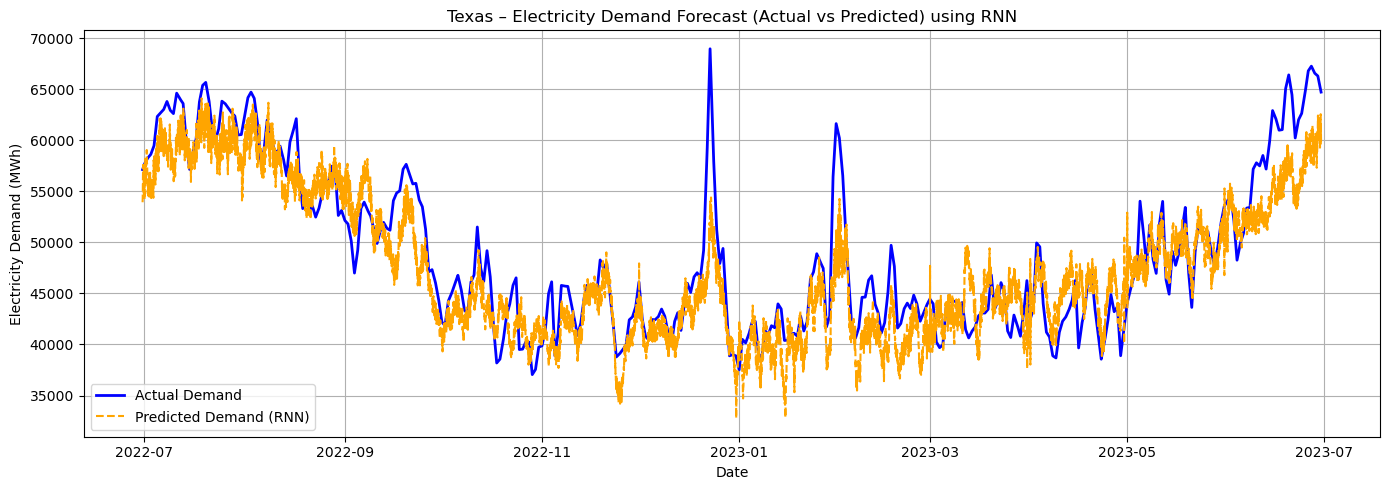

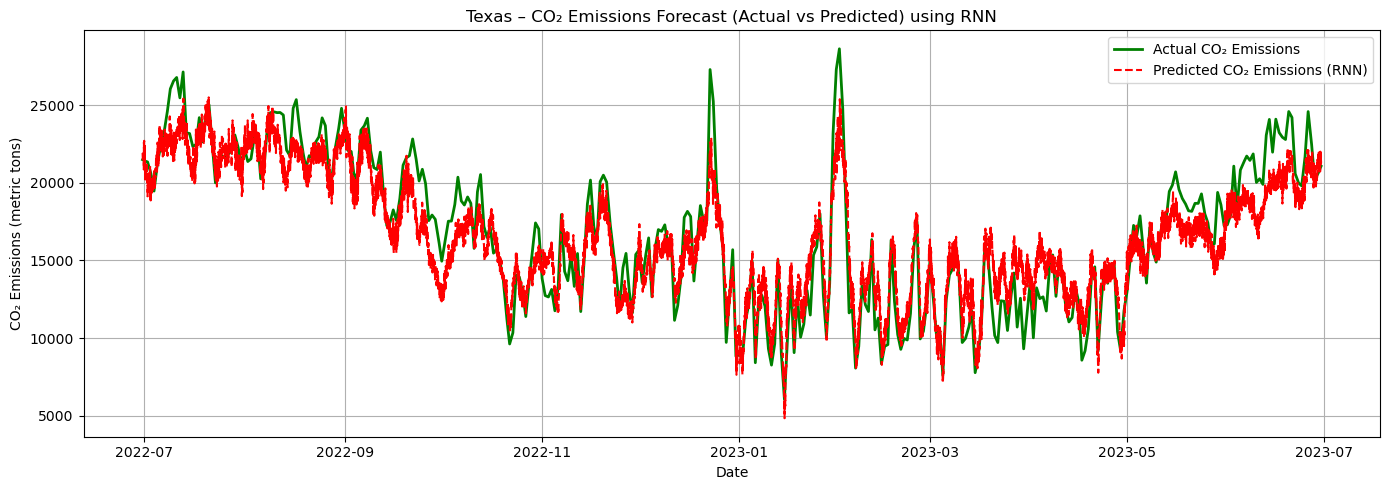

In [35]:
import matplotlib.pyplot as plt

# ----------------------
# Plot: Electricity Demand
# ----------------------
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true[:, 0], label='Actual Demand', color='blue', linewidth=2)
plt.plot(test_dates, y_pred[:, 0], label='Predicted Demand (RNN)', color='orange', linestyle='--')
plt.title('Texas – Electricity Demand Forecast (Actual vs Predicted) using RNN')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------
# Plot: CO₂ Emissions
# ----------------------
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_true[:, 1], label='Actual CO₂ Emissions', color='green', linewidth=2)
plt.plot(test_dates, y_pred[:, 1], label='Predicted CO₂ Emissions (RNN)', color='red', linestyle='--')
plt.title('Texas – CO₂ Emissions Forecast (Actual vs Predicted) using RNN')
plt.xlabel('Date')
plt.ylabel('CO₂ Emissions (metric tons)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# BOLTZMANN model


📊 Processing region: California
California - Demand RMSE: 2494.99, MAE: 1605.10, MAPE: 4.97%
California - CO₂ RMSE: 1113.51, MAE: 827.21, MAPE: 15.90%


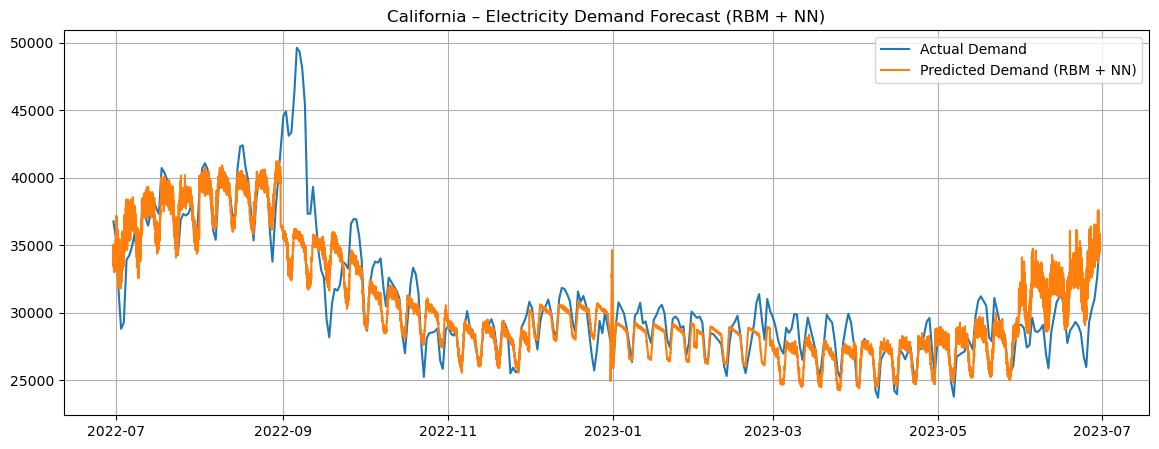

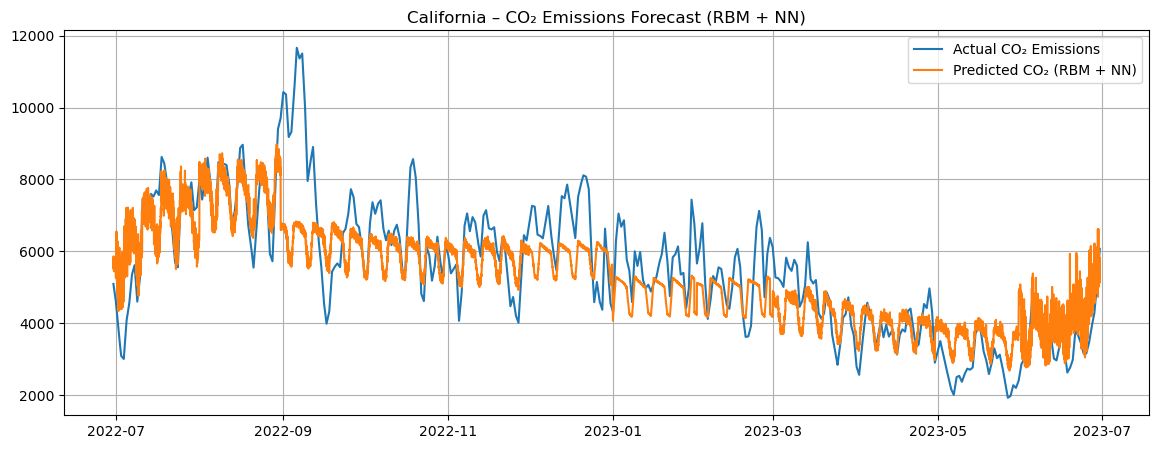


📊 Processing region: Texas
Texas - Demand RMSE: 4875.72, MAE: 3659.13, MAPE: 7.15%
Texas - CO₂ RMSE: 3209.02, MAE: 2422.79, MAPE: 17.84%


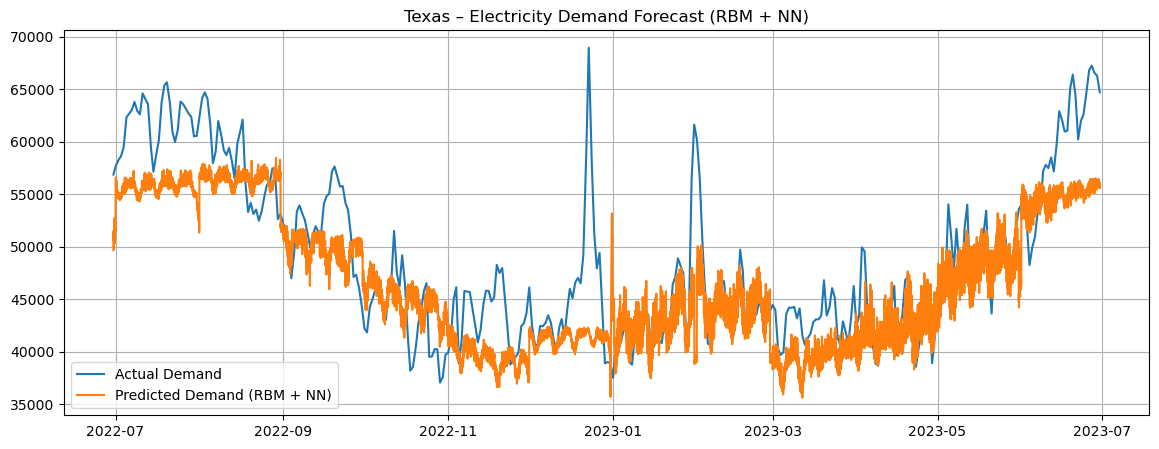

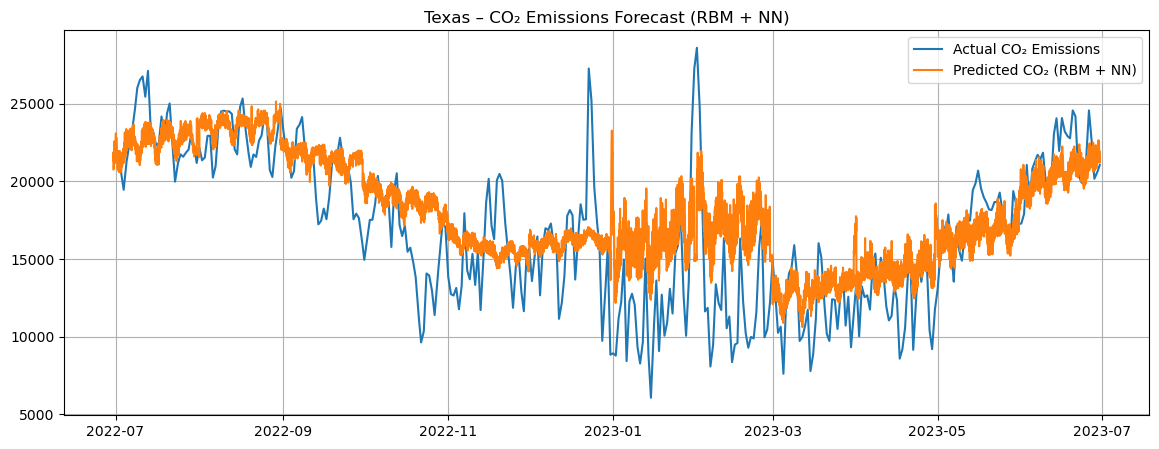

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define evaluation function
def evaluate_forecast(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# --------------------------
# Function for each region
# --------------------------
def rbm_forecasting(region_code, display_name):
    print(f"\n📊 Processing region: {display_name}")

    # Filter the data
    region_df = df[df['Region'] == region_code].copy()
    region_df['Date'] = pd.to_datetime(region_df['Date'])
    region_df.set_index('Date', inplace=True)

    # Daily aggregation
    daily_data = region_df.groupby(region_df.index).agg({
        'Demand': 'sum',
        'CO2_Total_Emissions': 'sum',
        'Hour': 'mean',
        'Month': 'mean',
        'DayOfWeek': 'mean',
        'Is_Weekend': 'mean',
        'DayOfYear': 'mean',
        'WeekOfYear': 'mean',
        'Season_Autumn': 'mean',
        'Season_Spring': 'mean',
        'Season_Summer': 'mean',
        'Season_Winter': 'mean',
        'Renewable_Pct': 'mean',
        'Fossil_Pct': 'mean',
        'Demand_Prev_Hour': 'mean',
        'Demand_Yesterday_Same_Hour': 'mean',
        'Demand_Last_Week_Same_Hour': 'mean',
        'Rolling_Mean_3H': 'mean',
        'Rolling_Mean_24H': 'mean'
    })

    features = daily_data[[
        'Hour', 'Month', 'DayOfWeek', 'Is_Weekend', 'DayOfYear', 'WeekOfYear',
        'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
        'Renewable_Pct', 'Fossil_Pct',
        'Demand_Prev_Hour', 'Demand_Yesterday_Same_Hour', 'Demand_Last_Week_Same_Hour',
        'Rolling_Mean_3H', 'Rolling_Mean_24H'
    ]]
    targets = daily_data[['Demand', 'CO2_Total_Emissions']]

    # Scaling
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(targets)

    # Train/Test split
    split = int(0.8 * len(X_scaled))
    X_train, X_test = X_scaled[:split], X_scaled[split:]
    y_train, y_test = y_scaled[:split], y_scaled[split:]
    test_dates = daily_data.index[split:]

    # Define RBM + NN pipeline
    rbm_nn = Pipeline(steps=[
        ('rbm', BernoulliRBM(n_components=64, learning_rate=0.06, n_iter=10, random_state=42)),
        ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64), activation='relu', max_iter=500, random_state=42))
    ])

    # Train the model
    rbm_nn.fit(X_train, y_train)

    # Predict
    y_pred_scaled = rbm_nn.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test)

    # ----------------------
    # Evaluation Metrics
    # ----------------------
    rmse_demand, mae_demand, mape_demand = evaluate_forecast(y_true[:, 0], y_pred[:, 0])
    rmse_co2, mae_co2, mape_co2 = evaluate_forecast(y_true[:, 1], y_pred[:, 1])

    print(f"{display_name} - Demand RMSE: {rmse_demand:.2f}, MAE: {mae_demand:.2f}, MAPE: {mape_demand:.2f}%")
    print(f"{display_name} - CO₂ RMSE: {rmse_co2:.2f}, MAE: {mae_co2:.2f}, MAPE: {mape_co2:.2f}%")

    # ----------------------
    # Plotting
    # ----------------------
    plt.figure(figsize=(14, 5))
    plt.plot(test_dates, y_true[:, 0], label='Actual Demand')
    plt.plot(test_dates, y_pred[:, 0], label='Predicted Demand (RBM + NN)')
    plt.title(f"{display_name} – Electricity Demand Forecast (RBM + NN)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(test_dates, y_true[:, 1], label='Actual CO₂ Emissions')
    plt.plot(test_dates, y_pred[:, 1], label='Predicted CO₂ (RBM + NN)')
    plt.title(f"{display_name} – CO₂ Emissions Forecast (RBM + NN)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Export Results to CSV
    result_df = pd.DataFrame({
        'Date': test_dates,
        'Region': display_name,
        'Actual_Demand': y_true[:, 0],
        'Predicted_Demand': y_pred[:, 0],
        'Actual_CO2': y_true[:, 1],
        'Predicted_CO2': y_pred[:, 1]
    })
   # result_df.to_csv(f"rbm_nn_forecast_{region_code.lower()}.csv", index=False)

    # Return metrics
    return {
        'Region': display_name,
        'Demand': {'RMSE': rmse_demand, 'MAE': mae_demand, 'MAPE': mape_demand},
        'CO2': {'RMSE': rmse_co2, 'MAE': mae_co2, 'MAPE': mape_co2}
    }

# ✅ Run for both California and Texas
cal_metrics = rbm_forecasting("CAL", "California")
tex_metrics = rbm_forecasting("TEX", "Texas")